# <center><u>Project 5 - Part 2 Core
* Authored By: Eric N. Valdez
* Date: 03/10/2024

# <u>Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer, make_column_selector,make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SequentialFeatureSelector

from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns',200)
pd.set_option("display.max_info_rows", 800)
pd.set_option('display.max_info_columns',800)

from sklearn import set_config
set_config(transform_output='pandas')

import warnings
warnings.filterwarnings("ignore")

# <u>Custom Functions

In [2]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [3]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

In [4]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [5]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

# <u>Load Data

In [6]:
# Loading the data
df = pd.read_csv('Data/Metabolic  Syndrome.csv')
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


In [7]:
# Looking infor on Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   seqn               int64  
 1   Age                int64  
 2   Sex                object 
 3   Marital            object 
 4   Income             float64
 5   Race               object 
 6   WaistCirc          float64
 7   BMI                float64
 8   Albuminuria        int64  
 9   UrAlbCr            float64
 10  UricAcid           float64
 11  BloodGlucose       int64  
 12  HDL                int64  
 13  Triglycerides      int64  
 14  MetabolicSyndrome  object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


In [8]:
df['seqn'].nunique()

2401

In [9]:
df = df.set_index('seqn')
df.head(3)

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn


In [10]:
df.duplicated().sum()

0

In [11]:
# Check missing values
df.isna().sum()

Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

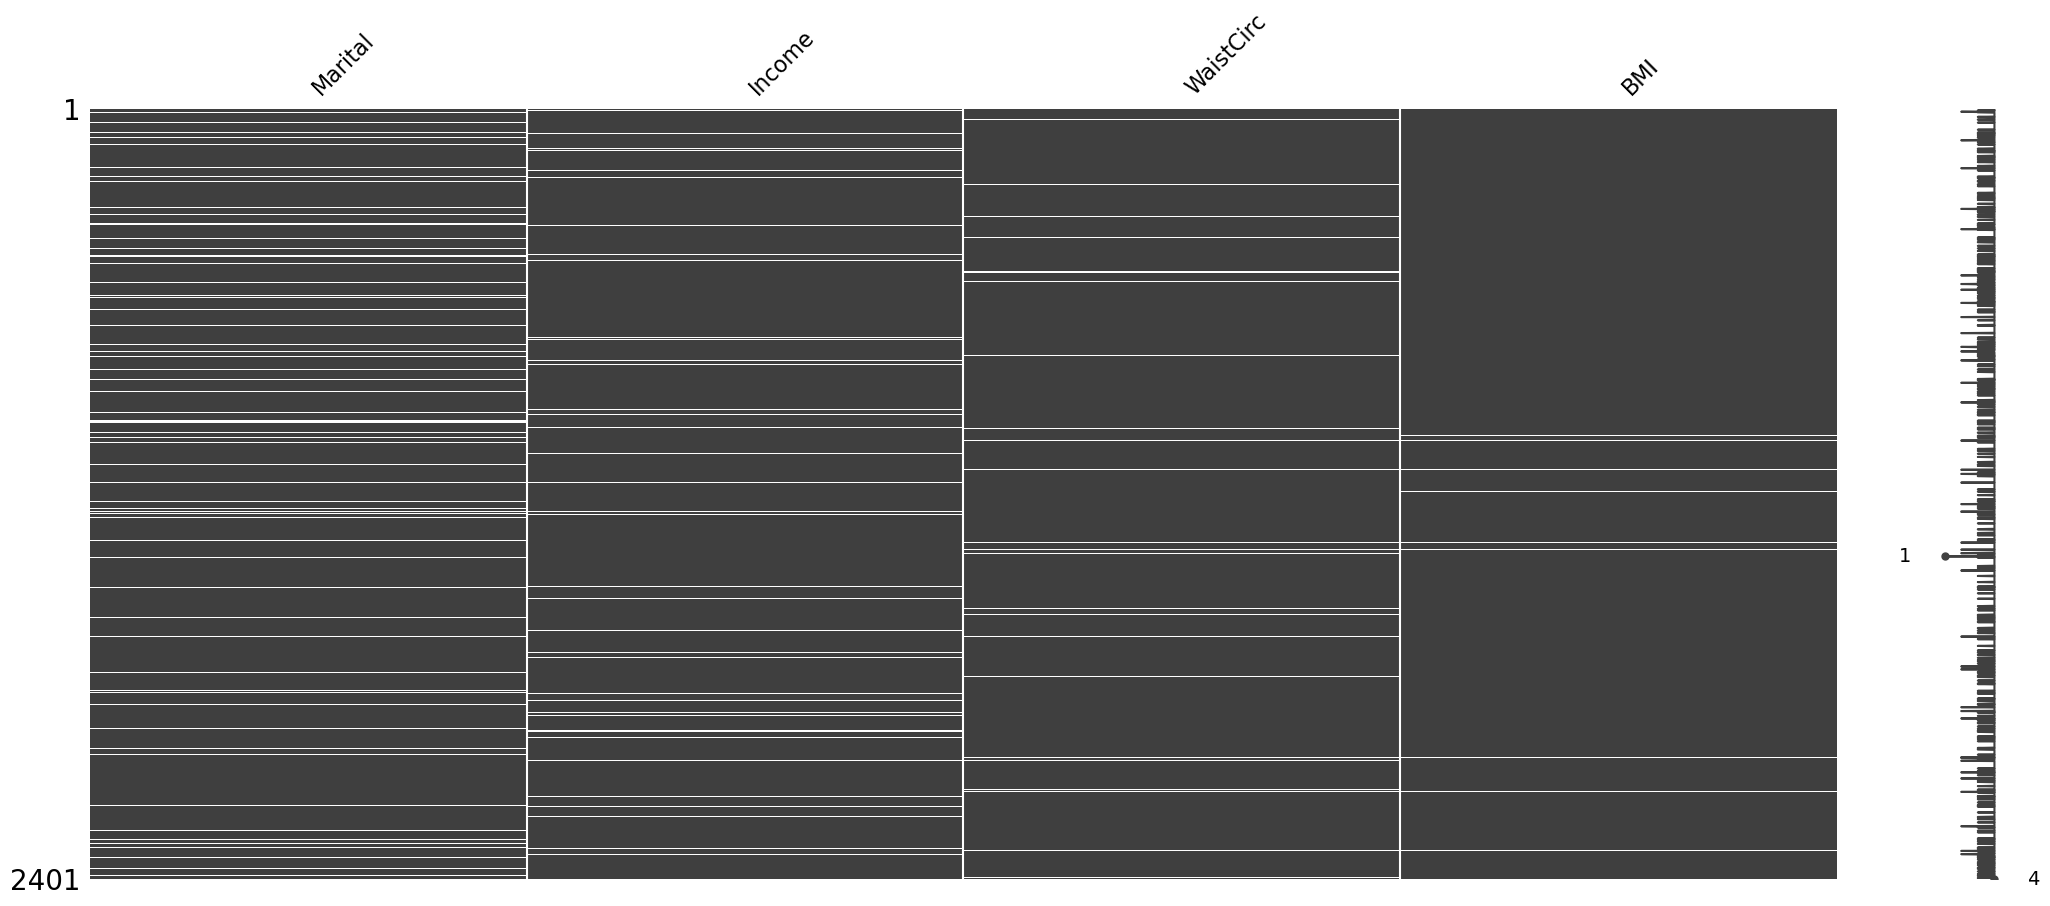

In [12]:
missingno.matrix(df[['Marital','Income','WaistCirc','BMI']]);

In [13]:
df['Marital'].value_counts()

Married      1192
Single        498
Divorced      242
Widowed       166
Separated      95
Name: Marital, dtype: int64

In [14]:
df['Marital'].isna().sum()

208

In [15]:
df.describe(include='object')

,Sex,Marital,Race,MetabolicSyndrome
count,2401,2193,2401,2401
unique,2,5,6,2
top,Female,Married,White,No MetSyn
freq,1211,1192,933,1579


In [16]:
df['Sex'].value_counts()

Female    1211
Male      1190
Name: Sex, dtype: int64

In [17]:
df['MetabolicSyndrome'].value_counts()

No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64

In [18]:
# Sex and MetabolicSyndrome binary encoding
df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0})
df['MetabolicSyndrome'] = df['MetabolicSyndrome'].map({'MetSyn': 1, 'No MetSyn': 0})
df.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,1,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,0
62164,44,0,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,0
62169,21,1,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
62172,43,0,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
62177,51,1,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0


In [19]:
df.describe(exclude='object')

,Age,Sex,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
count,2401.000000,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,48.691795,0.495627,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364,0.342357
std,17.632852,0.500085,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477,0.474597
min,20.000000,0.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000,0.000000
25%,34.000000,0.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000,0.000000
50%,48.000000,0.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000,0.000000
75%,63.000000,1.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000,1.000000
max,80.000000,1.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000,1.000000


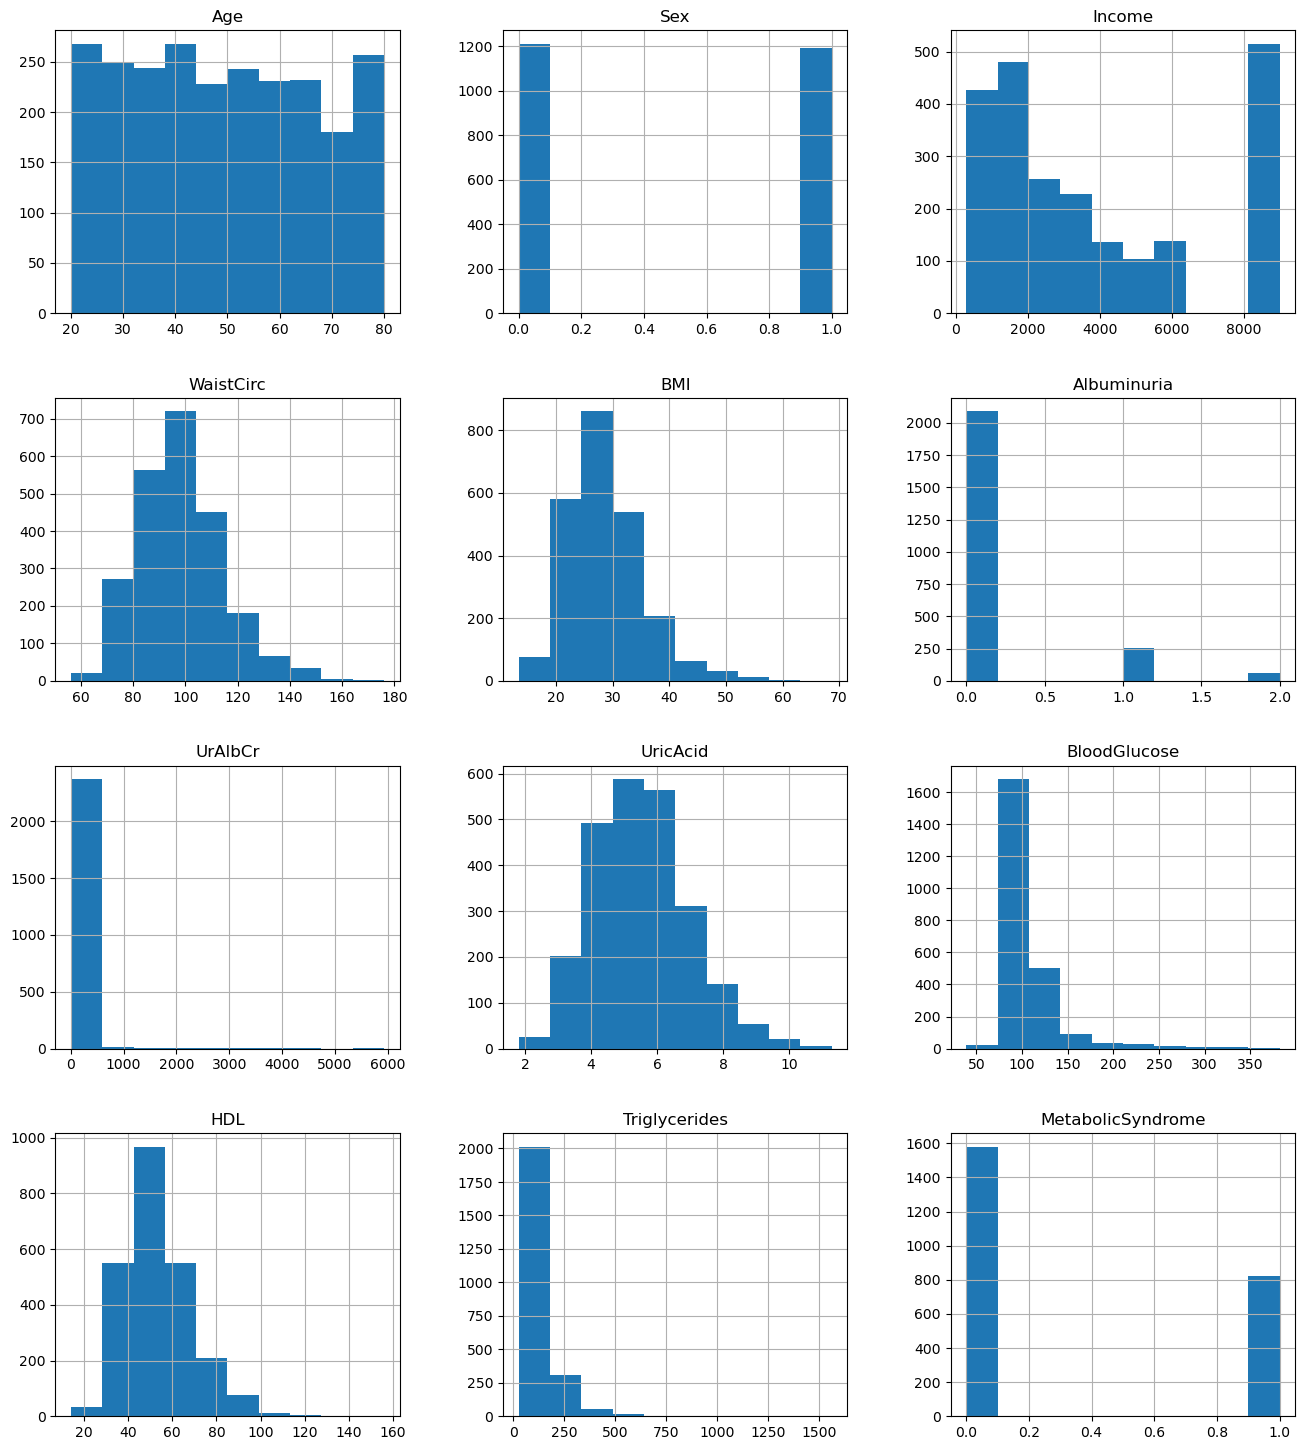

In [20]:
df.hist(figsize=(16,18));

Marital count plot 



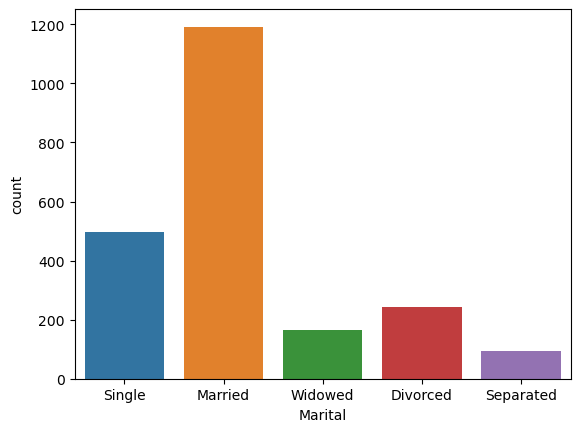

Race count plot 



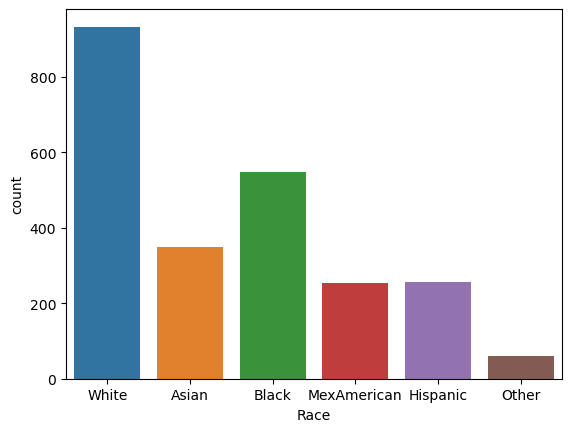

In [21]:
for col in df.select_dtypes('object').columns:
    print(col +' count plot \n') 
    sns.countplot(x =col, data =df)
    plt.show()

In [22]:
cat_cols = ['Sex', 'Marital','Race']
num_cols = ['Age','Income','WaistCirc','BMI','Albuminuria','UrAlbCr','UricAcid','BloodGlucose','HDL','Triglycerides']
#x train split
# Separating X,y and train test split
target = 'MetabolicSyndrome'
X = df.drop(columns=target).copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [23]:
# Categorical Pipeline / Tuple
# Using value 'Undisclosed' to fill in null values (all in 'Marital')
impute_missing = SimpleImputer(strategy='constant',fill_value='Undisclosed')
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

nom_pipe = make_pipeline(impute_missing, ohe_encoder, scaler)
nom_pipe

# Nominal Tuple
nom_tuple = ('categorical', nom_pipe, cat_cols)

nom_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='Undisclosed', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                 ('standardscaler', StandardScaler())]),
 ['Sex', 'Marital', 'Race'])

In [24]:
# Numeric Pipeline / Tuple
# Using median imputation strategy
mean_imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()
num_pipe = make_pipeline(mean_imputer, scaler)
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 ['Age',
  'Income',
  'WaistCirc',
  'BMI',
  'Albuminuria',
  'UrAlbCr',
  'UricAcid',
  'BloodGlucose',
  'HDL',
  'Triglycerides'])

In [25]:
preprocessor = ColumnTransformer([num_tuple, nom_tuple],
                                    verbose_feature_names_out=False, remainder='drop')

In [26]:
# Define KNN model pipeline
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Instantiate default KNN
knn = KNeighborsClassifier()
knn.fit(X_train_proc, y_train)

KNeighborsClassifier()

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1182
           1       0.85      0.69      0.76       618

    accuracy                           0.85      1800
   macro avg       0.85      0.81      0.83      1800
weighted avg       0.85      0.85      0.85      1800



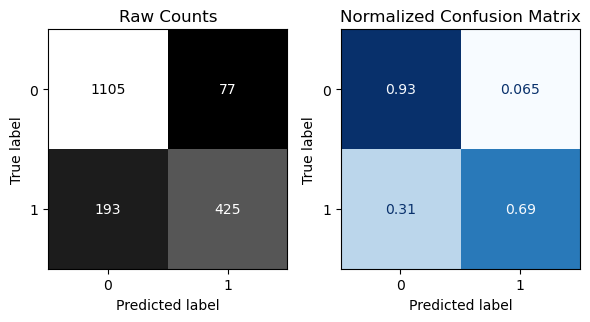


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       397
           1       0.69      0.56      0.62       204

    accuracy                           0.77       601
   macro avg       0.74      0.72      0.72       601
weighted avg       0.76      0.77      0.76       601



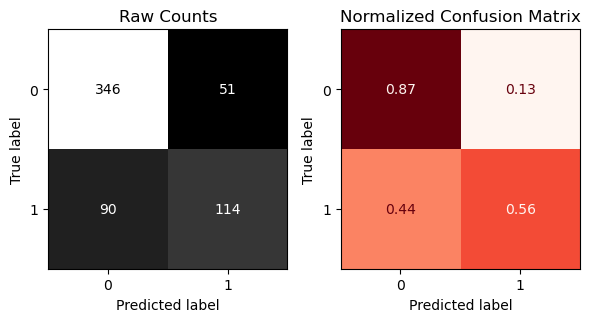

In [27]:
# evaluate
evaluate_classification(knn, X_train_proc, y_train, X_test_proc, y_test)

In [28]:
# Calculating feature importances
importances = permutation_importance(knn, X_test_proc, y_test)

# Creating a Series of Feature Importances
importances = pd.Series(importances['importances_mean'], index=knn.feature_names_in_)
importances = importances.sort_values(ascending=False)
importances.head(10)

Triglycerides          0.035275
BloodGlucose           0.022962
WaistCirc              0.016972
HDL                    0.016306
BMI                    0.010982
Age                    0.006323
Race_MexAmerican       0.005324
Race_Asian             0.003993
Marital_Undisclosed    0.002995
Marital_Single         0.002995
dtype: float64

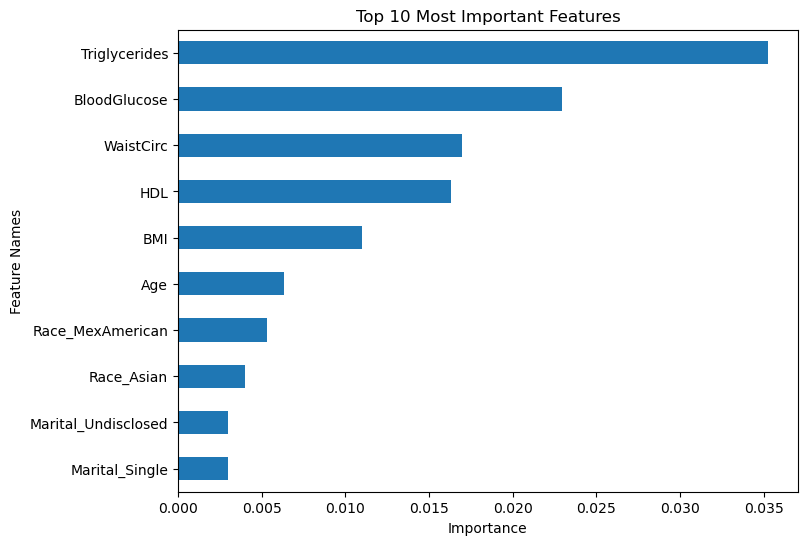

In [29]:
plot_importance(importances,top_n=10);

## Obervations:
* As expected the physical factors such as BMI/WaistCirc and Triglycerides are important
* Genetic Heritage (Race) also seems important, also making sense

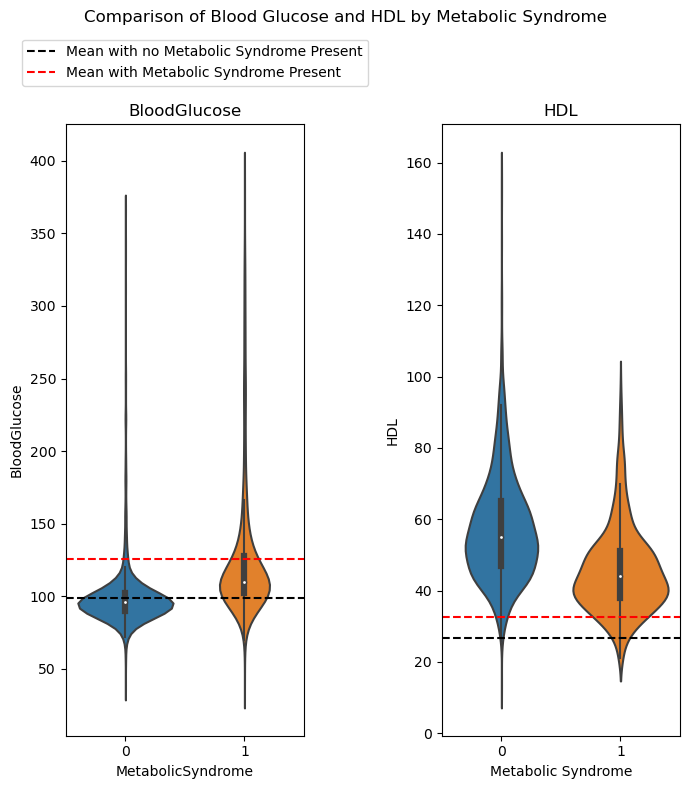

In [30]:
means_trig = df.groupby('MetabolicSyndrome')['BloodGlucose'].mean()
means_waist = df.groupby('MetabolicSyndrome')['BMI'].mean()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 8))

# Plot BloodGlucose violin plot
sns.violinplot(x="MetabolicSyndrome", y="BloodGlucose", data=df, ax=axes[0])
axes[0].axhline(y=means_trig[0], color='black', linestyle='--', 
                label='Mean with no Metabolic Syndrome Present')
axes[0].axhline(y=means_trig[1], color='red', linestyle='--', 
                label='Mean with Metabolic Syndrome Present')
axes[0].legend(bbox_to_anchor=(1.3, 1.15))
axes[0].set_title("BloodGlucose")

# Plot HDL violin plot
sns.violinplot(x="MetabolicSyndrome", y="HDL", data=df, ax=axes[1])
axes[1].axhline(y=means_waist[0], color='black', linestyle='--')
axes[1].axhline(y=means_waist[1], color='red', linestyle='--')
axes[1].set_title("HDL")

# Adjust labels and title
plt.xlabel("Metabolic Syndrome")
plt.suptitle("Comparison of Blood Glucose and HDL by Metabolic Syndrome")

# Tighten layout
plt.tight_layout()

In [31]:
plt.savefig('Images/Comparison of Blood Glucose and HDL by Metabolic Syndrome')

<Figure size 640x480 with 0 Axes>

* In both of these cases the mean is higher for those with Metabolic Syndrome.
* Higher Blood Glucose and HDL indicate higher risk of Metabolic Syndrome

# <u>`Part 2:`

* Apply PCA to get 3 principal components for the data. Concatenate/combine these PC’s with the original features (X_train, X_test data).
* ​Remember to only fit the PCA on the training data and use pca.transform(X_test) to get the PCs for the testing data.
* Apply clustering, select the appropriate number of clusters, and use the clustering object to get predicted cluster labels for the training and test data. Concatenate/combine these clusters with the original features.
* Remember to only fit KMeans on the training data and use kmeans.predict(X_test) to create cluster labels for the test data.
* Create additional features by applying the feature engineering techniques demonstrated in the LP.

* ### Fit and evaluate a model using your new features and compare it to your model from Part 1. 

## `PCA`

In [32]:
pca = PCA(n_components=.85)

In [33]:
# PCA randomforest
pca_rf = make_pipeline(preprocessor, pca)

* ## Apply at least one method of feature selection (filtering, embedded, wrapper) to your new features including engineered data.
Fit and evaluate a final model using the selected features. Compare it with previous models

In [34]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Classification Metrics
from sklearn.metrics import (ConfusionMatrixDisplay,
                             PrecisionRecallDisplay,
                             f1_score, accuracy_score, precision_score,
                             recall_score, classification_report)

In [35]:
def classification_metrics(y_true, y_pred, label='Metabolic Syndrome',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                         output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                         label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                        output_dict=True,figsize=figsize,
                                        colorbar=colorbar, cmap=cmap_test,
                                        label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict
# Define RanFor model pipeline
X_train_rf = preprocessor.fit_transform(X_train)
X_test_rf = preprocessor.transform(X_test)

# Create an instance of the model
rfc = RandomForestClassifier(random_state = 42)

In [36]:
X_train_pca = pca_rf.fit_transform(X_train)
X_test_pca = pca_rf.transform(X_test)

In [37]:
rfc_pca = RandomForestClassifier(random_state = 42)
rfc_pca.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

In [38]:
smote = SMOTE(random_state = 42)
X_train_sm,y_train_sm = smote.fit_resample(X_train_pca, y_train)
y_train_sm.value_counts()

1    1182
0    1182
Name: MetabolicSyndrome, dtype: int64

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1182
           1       1.00      1.00      1.00       618

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



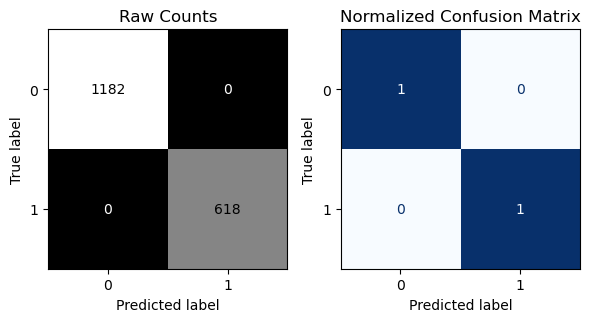


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       397
           1       0.76      0.72      0.74       204

    accuracy                           0.83       601
   macro avg       0.81      0.80      0.81       601
weighted avg       0.83      0.83      0.83       601



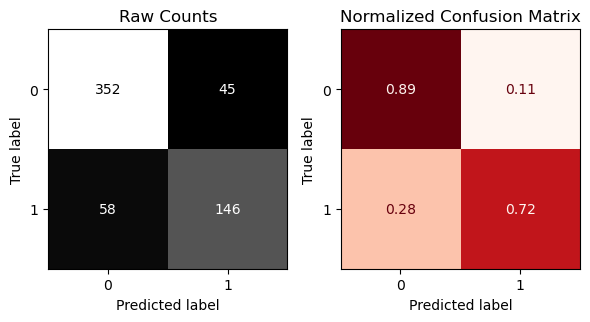

In [39]:
evaluate_classification(rfc_pca, X_train_pca, y_train,
                 X_test_pca, y_test)

Using PCA has created a model with about double the amount of false negatives. The accuracy decresed from 100% in the trainging to 83% in the test

## `Wrapper Method for Feature Selection`

In [40]:
from sklearn.feature_selection import SequentialFeatureSelector
rfw = RandomForestClassifier(random_state = 42)

In [41]:
X_train_f = preprocessor.fit_transform(X_train)
X_test_f = preprocessor.transform(X_test)

In [42]:
y.value_counts()

0    1579
1     822
Name: MetabolicSyndrome, dtype: int64

In [43]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_sm,y_train_sm = smote.fit_resample(X_train_f, y_train)
y_train_sm.value_counts()

1    1182
0    1182
Name: MetabolicSyndrome, dtype: int64

In [44]:
# Instantiate the SequentialFeatureSelector
sk_sfs = SequentialFeatureSelector(rfw, n_features_to_select=10,
                                direction = 'forward', cv=2,
                                 n_jobs=-1)
sk_sfs.fit(X_train_sm,y_train_sm)

SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(random_state=42),
                          n_features_to_select=10, n_jobs=-1)

In [45]:
# Preview array of T/F for selected (or not) features
sk_sfs.support_[0:5]

array([ True,  True,  True,  True, False])

* ## Extract and visualize the top 10 features using permutation importance (from Intro to ML Week 4). 

In [46]:
# .support_ returns an array of T/F whether it is above threshold
features_to_keep = sk_sfs.support_
# Only include the features selected
X_train_10 = X_train_sm.loc[:,features_to_keep]
X_test_10 = X_test_f.loc[:,features_to_keep]
X_train_10.shape

(2364, 10)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1182
           1       1.00      1.00      1.00      1182

    accuracy                           1.00      2364
   macro avg       1.00      1.00      1.00      2364
weighted avg       1.00      1.00      1.00      2364



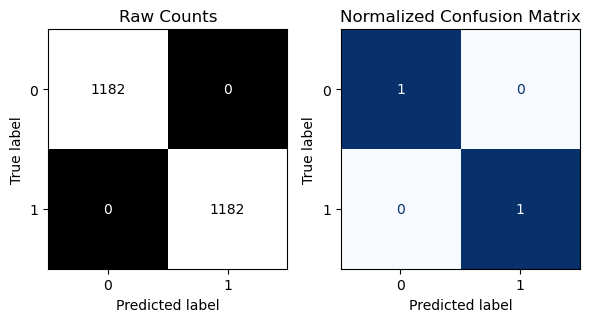


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       397
           1       0.80      0.86      0.83       204

    accuracy                           0.88       601
   macro avg       0.86      0.88      0.87       601
weighted avg       0.88      0.88      0.88       601



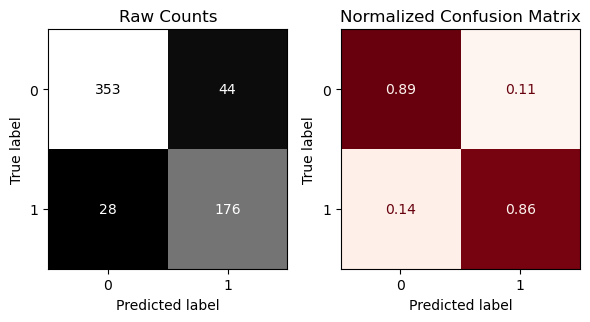

In [47]:
# Instantiate default random forest
rf_clf = RandomForestClassifier(random_state=42)
# Fit on 10 selected featuers
rf_clf.fit(X_train_10, y_train_sm)
# Evaluate with custom function
evaluate_classification(rf_clf, X_train_10, y_train_sm, X_test_10, y_test)

The Accuracy is low on the Test at 88% and 100% on the training. Not a big fan of the matrix.but did improve by 2%.

In [48]:
# Calculate feature importances
importances2 = permutation_importance(rf_clf, X_test_10, y_test)

# Create a Series of Feature Importances
importances2 = pd.Series(importances2['importances_mean'], index=rf_clf.feature_names_in_)
importances2 = importances2.sort_values(ascending=False)
importances2.head(10)

BloodGlucose      0.096173
Triglycerides     0.070882
WaistCirc         0.039601
Sex_1             0.030616
BMI               0.016306
Age               0.013644
HDL               0.013311
Income           -0.000666
Race_Hispanic    -0.000998
Marital_Single   -0.003661
dtype: float64

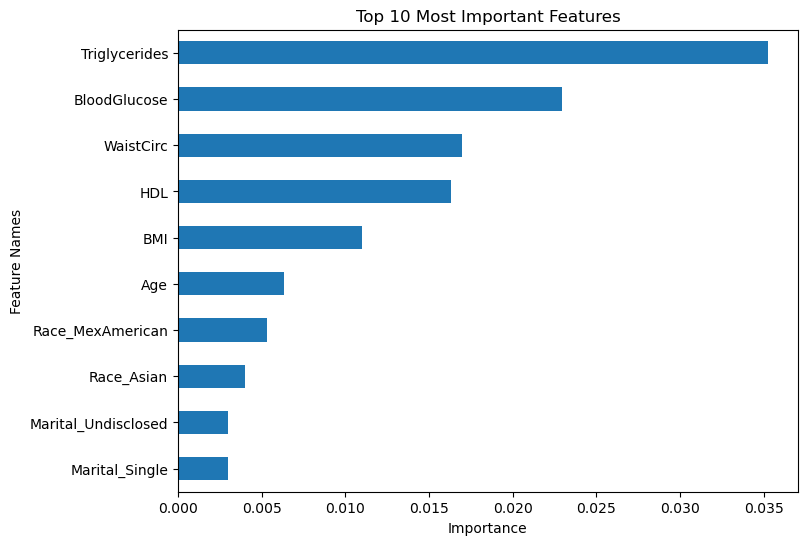

In [49]:
plot_importance(importances,top_n=10);

* ## In a Markdown cell, comment on how these features compare to the model from Part 1. Are there any new features in the top 10?

### Tryglycerrides are a lot higher on this feature, where on Part one my BloodGlucose was highest, also everything under my BMI changed, Age was lower in part 1, now its higher, also Race changed from Black to Mexican and Asian, Marital Undiclosed was added and whether you were Single was also added. My 1st plot showed Sex both male and female.